# Rossmann Sales Prediction

This notebooks tackles the Rossmann Sales Prediction challenge from Kaggle in 2015. As the name suggests, the challenge lies in predicting the number of sales a certain store generates on a specific day.

Even though, I am aware that many people published their top-ranked solution, I instead tried to not focus my work on what other people did in this competition.
Rather, I approached it like an original problem for which you cannot find existing solutions from hundreds of other people.

The notebook is structured as follows:

**1. Load the Data:**
First, we load all the data necessary to coduct our experiments.

**2. Exploratory Data Analysis:**
In the next step, we will take a closer look at the data in order to better understand it and get a feeling for which algorithms could work and which not.

**3. Feature Engineering:**
In addition to the features provided by the dataset, we will generate some richer features on our own.

**4. Model Training and Evaluation:**
Here we train and evaluate our actual models for the sales prediction task.

**5. Future Work:**
Afterwards, we discuss some approaches to could improve our results but were not possible to time/ressource limitations.

**6. Conclusion:**
At last, we discuss have we have built so far.

![alt text](https://kaggle2.blob.core.windows.net/competitions/kaggle/4594/media/rossmann_banner2.png)

This notebook was run using Python 3.6 with the following libraries:
- h5py
- keras
- matplotlib
- numpy
- pandas
- seaborn
- sklearn
- statsmodels
- tensorflow
- xgboost

## Loading the Data

We first upload our CSV files to Colab notebook or use the local data instead.

In [1]:
import os

COLAB = False

if COLAB:
    from google.colab import files
    uploaded = files.upload()
    
    if not os.path.exists('data'):
        os.makedirs('data')

    for fname, content in uploaded.items():
        with open(os.path.join('data', fname), 'wb') as f:
            f.write(content)

In [2]:
if not os.path.exists('models'):
        os.makedirs('models')
if not os.path.exists('histories'):
        os.makedirs('histories')

In [3]:
!ls

data                 models
histories            rossmann_sales.ipynb


To start with, we build our Pandas DataFrames that allow us to efficiently explore and manipulate our data.

In [4]:
from datetime import datetime
import pandas as pd

In [5]:
train_df = pd.read_csv('data/train.csv', parse_dates=['Date'], low_memory=False)
test_df = pd.read_csv('data/test.csv', parse_dates=['Date'])

In [6]:
# Spread date over multiple columns
for df in [train_df, test_df]:
    df['day'] = df.Date.dt.day
    df['week'] = df.Date.dt.week
    df['month'] = df.Date.dt.month
    df['year'] = df.Date.dt.year

Next we add some additional data on the stores.

In [7]:
store_df = pd.read_csv('data/store.csv')

# Join the sales and store tables.
train_df = pd.merge(train_df, store_df, on='Store')
test_df = pd.merge(test_df, store_df, on='Store')

# Remove store table from memory.
del store_df

Additionaly, we have a few CSV files that other participants built, so we will include those as well.

For example this includes the German states (as abbreviations) that the stores are located at.

In [8]:
store_states_df = pd.read_csv('data/store_states.csv')

train_df = pd.merge(train_df, store_states_df, on='Store')
test_df = pd.merge(test_df, store_states_df, on='Store')

del store_states_df

Also, we will add the full state names which are mainly needed to later join our weather data.

In [9]:
state_names_df = pd.read_csv('data/state_names.csv')

train_df = train_df.merge(state_names_df, on='State')
test_df = test_df.merge(state_names_df, on='State')

del state_names_df

The weather data contains many weather phenomena that could relate to the amount of sales.

In [10]:
weather_df = pd.read_csv('data/weather.csv', parse_dates=['Date'])
# Correct name of 'file' column to 'StateName'
weather_df = weather_df.rename(index=str, columns={'file': 'StateName'})

print("'weather.csv' adds the following columns:")
print(weather_df.columns)

train_df = train_df.merge(weather_df, on=['Date', 'StateName'])
test_df = test_df.merge(weather_df, on=['Date', 'StateName'])

del weather_df
# StateName is not needed any longer.
del train_df['StateName']
del test_df['StateName']

'weather.csv' adds the following columns:
Index(['StateName', 'Date', 'Max_TemperatureC', 'Mean_TemperatureC',
       'Min_TemperatureC', 'Dew_PointC', 'MeanDew_PointC', 'Min_DewpointC',
       'Max_Humidity', 'Mean_Humidity', 'Min_Humidity',
       'Max_Sea_Level_PressurehPa', 'Mean_Sea_Level_PressurehPa',
       'Min_Sea_Level_PressurehPa', 'Max_VisibilityKm', 'Mean_VisibilityKm',
       'Min_VisibilitykM', 'Max_Wind_SpeedKm_h', 'Mean_Wind_SpeedKm_h',
       'Max_Gust_SpeedKm_h', 'Precipitationmm', 'CloudCover', 'Events',
       'WindDirDegrees'],
      dtype='object')


Also, we add some Google trends that could indicate the popularity of the Rossmann brand for certains dates.

In [11]:
# Has both global trend for Germany as well as trends for single states.
parse_trends_date = lambda d: datetime.strptime(d.split(' - ')[0], '%Y-%m-%d')
googletrend_df = pd.read_csv('data/googletrend.csv', parse_dates=['week'],
                             date_parser=parse_trends_date)
googletrend_df['week'] = googletrend_df['week'].dt.week

global_trends_df = googletrend_df[googletrend_df.file == 'Rossmann_DE']
assert len(set(global_trends_df.file)) == 1
# 'file' column no longer needed -> remove
del global_trends_df['file']

train_df = train_df.merge(global_trends_df, on='week')
test_df = test_df.merge(global_trends_df, on='week')

del global_trends_df

local_trends_df = googletrend_df[googletrend_df.file != 'Rossmann_DE']
assert 'Rossmann_DE' not in local_trends_df.file
# Extract state.
local_trends_df.file = local_trends_df.file.apply(lambda x: x.split('_')[-1])
local_trends_df = local_trends_df.rename(index=str,
                                         columns={'file': 'State',
                                                  'trend': 'global_trend'})

train_df = train_df.merge(local_trends_df, on=['week', 'State'])
test_df = test_df.merge(local_trends_df, on=['week', 'State'])

del local_trends_df

/Users/florian/miniconda3/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [12]:
# Put train and test datasets in a list to easier apply changes to both.
df_list = [train_df, test_df]

In [13]:
# Lowercase all column names for convenience and consistency.
for df in df_list:
    df.columns = map(lambda col_name: col_name.lower(), df.columns)

In [14]:
# Show all distinct values per object type.
for col_name in train_df.select_dtypes(include='object'):
    print("%s: " % col_name)
    print(set(train_df[col_name]))

stateholiday: 
{'0', 'c', 'a', 'b'}
storetype: 
{'d', 'a', 'c', 'b'}
assortment: 
{'a', 'c', 'b'}
promointerval: 
{nan, 'Jan,Apr,Jul,Oct', 'Mar,Jun,Sept,Dec', 'Feb,May,Aug,Nov'}
state: 
{'BE', 'TH', 'HH', 'NW', 'HE', 'BY', 'ST', 'SH', 'SN', 'RP', 'BW'}
events: 
{nan, 'Fog-Snow-Hail', 'Fog-Rain', 'Fog-Rain-Hail-Thunderstorm', 'Rain-Snow', 'Thunderstorm', 'Rain', 'Fog-Thunderstorm', 'Fog', 'Rain-Hail', 'Rain-Snow-Hail', 'Fog-Snow', 'Fog-Rain-Snow-Hail', 'Snow-Hail', 'Fog-Rain-Hail', 'Rain-Thunderstorm', 'Rain-Hail-Thunderstorm', 'Fog-Rain-Snow', 'Rain-Snow-Hail-Thunderstorm', 'Rain-Snow-Thunderstorm', 'Fog-Rain-Thunderstorm', 'Snow'}


In [15]:
# Transform objects types to categories so that they are easier to process.
for col_name in train_df.select_dtypes(include='object'):
    train_df[col_name] = train_df[col_name].astype('category').cat.as_ordered()

In [16]:
# Check if everything looks right.
print(train_df.dtypes)
# print(train_df.describe())
train_df.head()

store                                  int64
dayofweek                              int64
date                          datetime64[ns]
sales                                  int64
customers                              int64
open                                   int64
promo                                  int64
stateholiday                        category
schoolholiday                          int64
day                                    int64
week                                   int64
month                                  int64
year                                   int64
storetype                           category
assortment                          category
competitiondistance                  float64
competitionopensincemonth            float64
competitionopensinceyear             float64
promo2                                 int64
promo2sinceweek                      float64
promo2sinceyear                      float64
promointerval                       category
state     

,store,dayofweek,date,sales,customers,open,promo,stateholiday,schoolholiday,day,...,min_visibilitykm,max_wind_speedkm_h,mean_wind_speedkm_h,max_gust_speedkm_h,precipitationmm,cloudcover,events,winddirdegrees,trend,global_trend
0,1,5,2015-07-31,5263,555,1,1,0,1,31,...,10.0,24,11,NaN,0.0,1.0,Fog,13,60,62
1,1,5,2015-07-31,5263,555,1,1,0,1,31,...,10.0,24,11,NaN,0.0,1.0,Fog,13,60,77
2,1,5,2015-07-31,5263,555,1,1,0,1,31,...,10.0,24,11,NaN,0.0,1.0,Fog,13,60,85
3,1,5,2015-07-31,5263,555,1,1,0,1,31,...,10.0,24,11,NaN,0.0,1.0,Fog,13,74,62
4,1,5,2015-07-31,5263,555,1,1,0,1,31,...,10.0,24,11,NaN,0.0,1.0,Fog,13,74,77


## Exploratory Data Analysis (EDA)

From [Kaggle](https://www.kaggle.com/c/rossmann-store-sales/data):

Most of the fields are self-explanatory. The following are descriptions for those that aren't.
 - **Id** - an Id that represents a (Store, Date) duple within the test set
 - **Store** - a unique Id for each store
 - **Sales** - the turnover for any given day (this is what you are predicting)
 - **Customers** - the number of customers on a given day
 - **Open** - an indicator for whether the store was open: 0 = closed, 1 = open
 - **StateHoliday** - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
 - **SchoolHoliday** - indicates if the (Store, Date) was affected by the closure of public schools
 - **StoreType** - differentiates between 4 different store models: a, b, c, d
 - **Assortment** - describes an assortment level: a = basic, b = extra, c = extended
 - **CompetitionDistance** - distance in meters to the nearest competitor store
 - **CompetitionOpenSince[Month/Year]** - gives the approximate year and month of the time the nearest competitor was opened
 - **Promo** - indicates whether a store is running a promo on that day
 - **Promo2** - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
 - **Promo2Since[Year/Week]** - describes the year and calendar week when the store started participating in Promo2
 - **PromoInterval** - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.formula.api as sm
from statsmodels.graphics.tsaplots import plot_acf

/Users/florian/miniconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


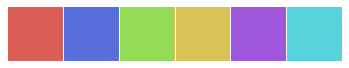

In [18]:
# Increase font size for better readability.
sns.set(font_scale=1.5)

# Set custom colors for graphs.
colors = np.array(sns.color_palette('hls', 8))
colors = colors[[0, 5, 2, 1, 6, 4]]
sns.set_palette(colors)
sns.palplot(sns.color_palette())

In [19]:
print("# Total training observations: %d" % len(train_df))
print("# Total test observations: %d" % len(test_df))

# Total training observations: 8406685
# Total test observations: 360288


Over 8 million observations suggest that we might have to care about in-memory processing.
Therefore, we create a sampled subset for operations that cannot be run on the whole dataset.

In [20]:
sampled_df = train_df.sample(frac=0.05)

#### Some helper functions

In [21]:
def plot_correlation_matrix(df, method='pearson', figsize=(11, 9)):
    """Plots a correlation matrix given the provided method."""
    # Compute the correlation matrix.
    corr = df.corr(method=method)

    # Generate a mask for the upper triangle.
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure.
    f, ax = plt.subplots(figsize=figsize)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
              square=True, linewidths=.5, cbar_kws={"shrink": .5});

In [22]:
def print_anova_results(explanatory_variable, response_variable):
    """Builds an ANOVA model and prints out the shortened results."""

    # Make sure variable names are passed in as strings.
    assert isinstance(explanatory_variable, str)
    assert isinstance(response_variable, str)

    model = sm.ols(formula='%s ~ C(%s)'
                 % (response_variable, explanatory_variable),
                 data=train_df)
    results = model.fit()

    lines = str(results.summary()).split('\n')
    header = lines[0].replace('OLS Regression', '    ANOVA')
    dep_var_r_squared = lines[1:3]
    coeffs = lines[11:-8]

    output_lines = [header] + dep_var_r_squared + coeffs

    print('\n'.join(output_lines))

### Sales

We will start our analysis with some basic assessment of the _sales_ variable.

In [23]:
total_sales = sum(train_df['sales'])
print("# Total sales: %d" % total_sales)
print("# Sales per store per day: %d" % (total_sales / len(train_df)))

# Total sales: 48494735481
# Sales per store per day: 5768


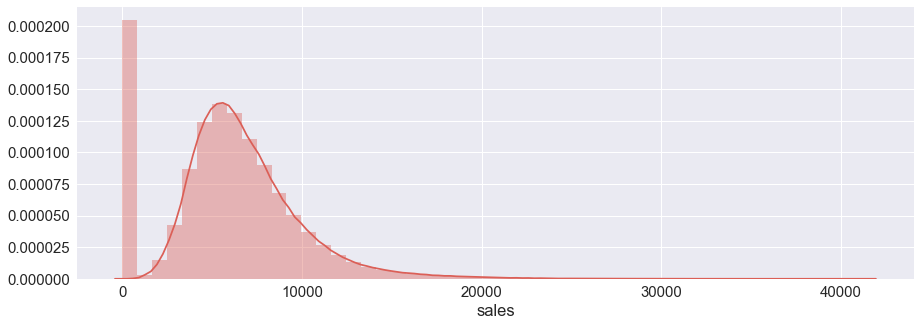

In [24]:
plt.figure(figsize=(15, 5))
sns.distplot(train_df['sales']);

While our distribution looks somewhat like a bell curve, it is slightly right skewed with a large number of zero sales on right. Those might mainly be Sundays and holidays.

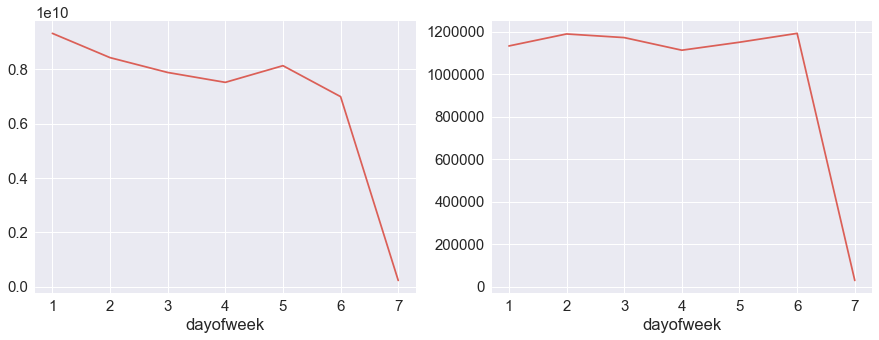

In [25]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
train_df.groupby('dayofweek')['sales'].sum().plot()
plt.subplot(122)
train_df.groupby('dayofweek')['open'].sum().plot();

In [26]:
train_df.groupby('dayofweek')['sales', 'open'].sum()

,sales,open
dayofweek,,
1,9320079966,1132412
2,8427062799,1188878
3,7881015650,1171785
4,7517003222,1112447
5,8130245197,1149974
6,6991279784,1191720
7,228048863,29316


Grouping the sales by days of the week clearly shows that significantly less sales are made on Sundays (unsurprisingly.

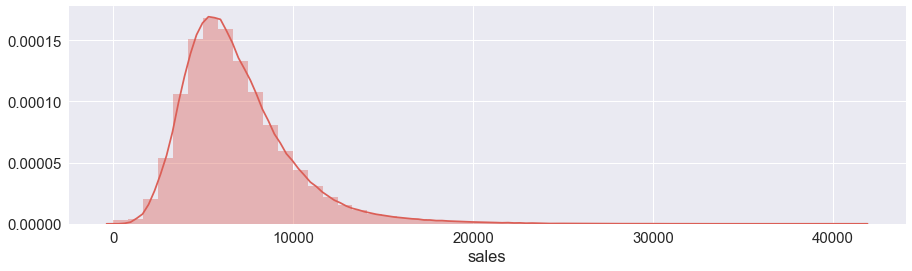

In [27]:
workday_sales = train_df[(train_df.dayofweek != 7)
                         & (train_df.stateholiday.astype('str') == '0')
                         & (train_df.schoolholiday == 0)]['sales']
plt.figure(figsize=(15, 4))
sns.distplot(workday_sales);

In [28]:
print(1 - workday_sales.sum() / total_sales)

0.20662037010029233


And indeed, after removing Sundays and holidays, we have basically no 'zero sales' left.

In [29]:
len(train_df[(train_df.open == 1) & (train_df.sales == 0)])

481

#### Sales History

When plotting the number of sales over the years, we immediately recognize a strong seasonality, which we will explore in the following.

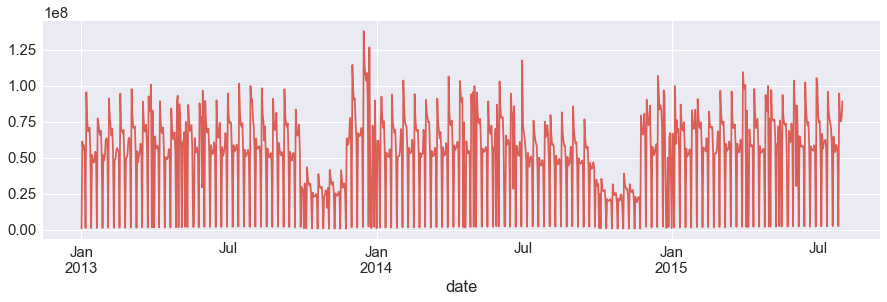

In [30]:
sales_history = train_df.set_index(train_df.date).sales.resample('D').sum()
plt.figure(figsize=(15, 4))
sales_history.plot();

One thing we cannot explain is why the Christmas trend in 2014 is much stronger than in 2015.

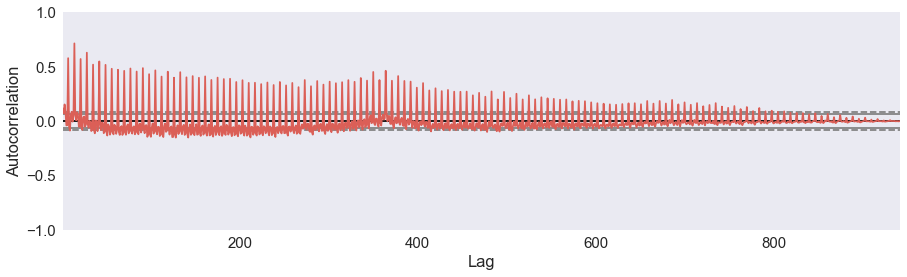

In [31]:
plt.figure(figsize=(15, 4))
pd.plotting.autocorrelation_plot(sales_history);

#### Sales for Different Time Units

In [32]:
def plot_sales_per(date_unit):
    plt.figure(figsize=(12, 4))
    plt.subplot(121)
    train_df.groupby(train_df[date_unit])['sales'].sum().plot()
    plt.subplot(122)
    train_df.groupby(train_df[date_unit])['sales'].mean().plot();

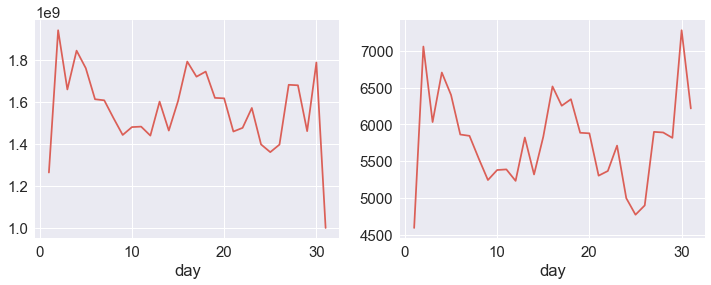

In [33]:
plot_sales_per('day')

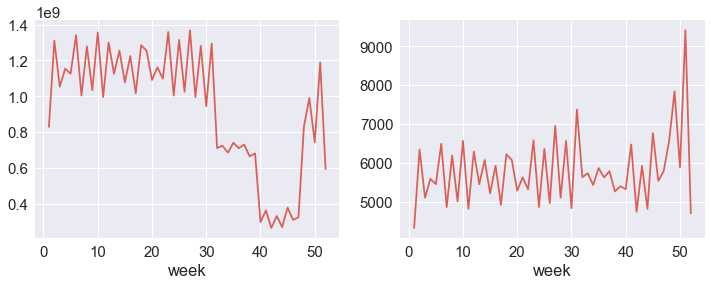

In [34]:
plot_sales_per('week')

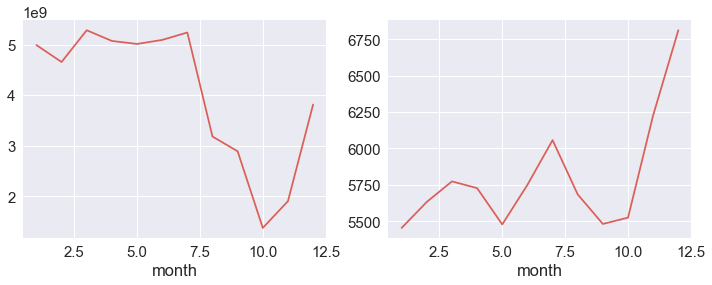

In [35]:
plot_sales_per('month')

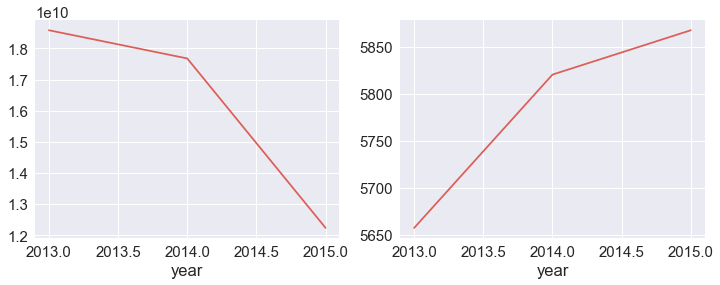

In [36]:
plot_sales_per('year')

**Sales per Day**

Plotting the average sales per day shows strong peaks at the beginning and the middle of the month. This is most likely due to the fact that people are getting paid at those times and thus have more money to spend. The steep drop and the end of the month is obviously because no all months have 31 days.

**Sales per Month**

Thr most obvious observation is the strong Christmas peak and the low in sales before that.

**Sales per Year**

The fact that the total sales go down will the average sales go up over the years can only mean that more stores are closing but the ones left are more profitable.

### Costumers / Open

The explanatory variables _customers_ and _open_ and probably the two most straight-forward ones in our dataset.
With more customers coming to a store, we would also expect more sales being generated.
The _open_ variable should be expected to behave like an on/off switch:
When a store has opened, it should generate sales and if it is closed, it does not.
Yet, it should by obvious that the _open_ variable itself is highly dependant on _date_ and holidays (to be aware of for models that assume the independency of variables).

In [37]:
print(train_df[train_df.open == 0]['sales'].sum())
print(train_df[train_df.open == 0]['customers'].sum())

0
0


As a quick sanity check, we see that when a store is not open, it has neither sales nor customers.

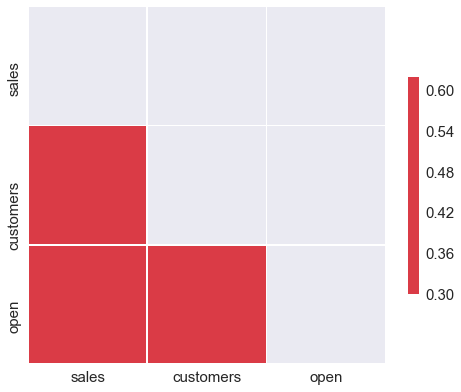

In [38]:
plot_correlation_matrix(train_df[['sales', 'customers', 'open']], figsize=(8, 8))

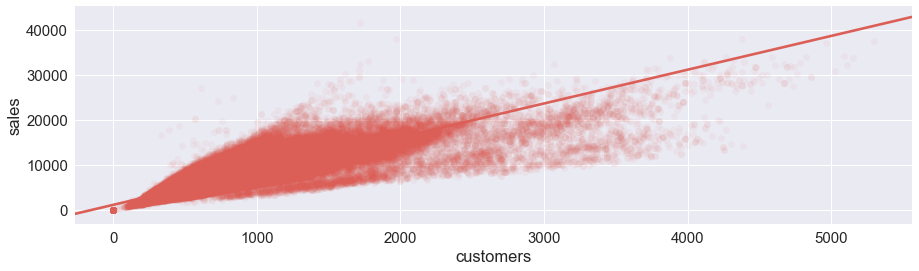

In [39]:
plt.figure(figsize=(15, 4))
sns.regplot(x='customers', y='sales', data=sampled_df, scatter_kws={'alpha': 1/20});

Unsurprsingly, the correlation matrix tells us that all three variables _sales_, _customers_, and _open_ are strongly correlated.
One thing to keep in mind though is the increasing variance for the residuals as the number of customers increases.
This will make methods like Linear Regression that assume homoscedasticity most likely perform poorly.

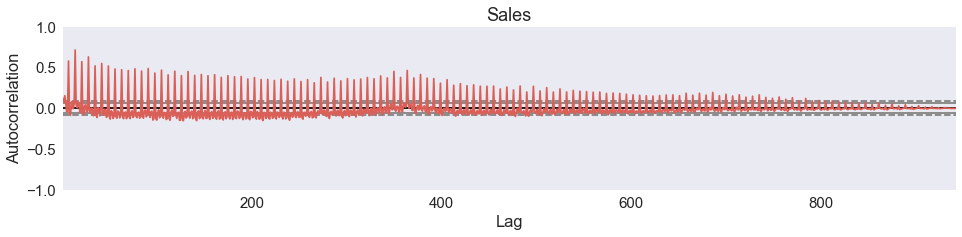

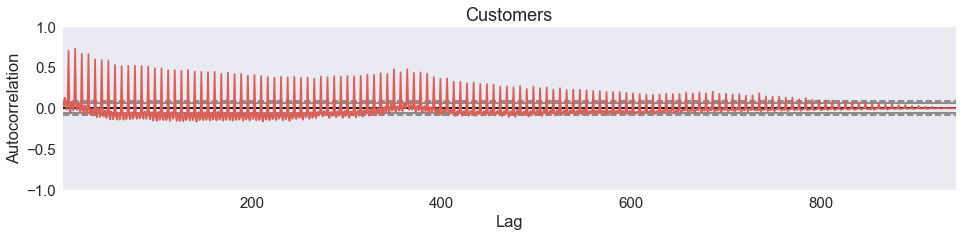

In [40]:
customers_history = train_df.set_index(train_df.date).customers.resample('D').sum()
plt.figure(figsize=(16, 3))
pd.plotting.autocorrelation_plot(sales_history)
plt.title('Sales')
plt.show()
plt.figure(figsize=(16, 3))
pd.plotting.autocorrelation_plot(customers_history)
plt.title('Customers');

Also, when looking at the autocorrelation of _sales_ and _customers_, we see that both behave very similar.

### Promo

As mentioned ealier, there are two types of promotions which we will inspect seperately. 

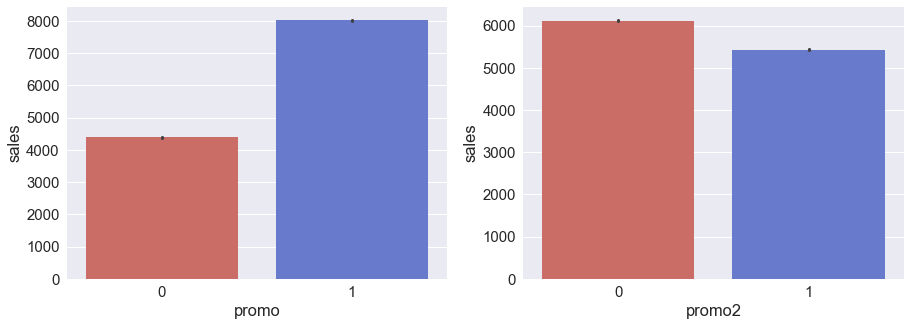

In [44]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
sns.barplot(x='promo', y='sales', data=sampled_df)
plt.subplot(122)
sns.barplot(x='promo2', y='sales', data=sampled_df);

In [45]:
print_anova_results('promo', 'sales')

                                ANOVA Results                            
Dep. Variable:                  sales   R-squared:                       0.206
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      4397.8563      1.504   2923.916      0.000    4394.908    4400.804
C(promo)[T.1]  3603.2797      2.439   1477.576      0.000    3598.500    3608.059


In [46]:
print_anova_results('promo2', 'sales')

                                ANOVA Results                            
Dep. Variable:                  sales   R-squared:                       0.008
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       6124.4041      1.895   3231.926      0.000    6120.690    6128.118
C(promo2)[T.1]  -694.5745      2.648   -262.342      0.000    -699.764    -689.385


While both ANOVA experiments suggest a significant difference (according to their p-values below 0.001), we have to be aware that this might also be cause by the large sample size that easily causes small p-values.
When looking at the squared residuals however, we notice that the presence of a type 1 promo increases the number of sales by roughly 80%.
Unintuitively though, the presence of a type 2 promo actually decreses the number of sales.

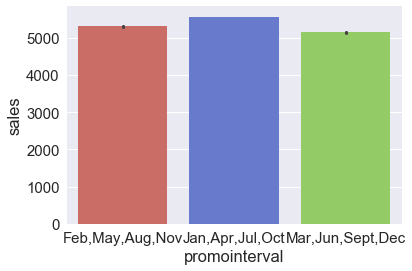

In [47]:
sns.barplot(x='promointerval', y='sales', data=train_df);

In [48]:
print_anova_results('promointerval', 'sales')

                                ANOVA Results                            
Dep. Variable:                  sales   R-squared:                       0.002
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                             5313.5807      3.511   1513.453      0.000    5306.699    5320.462
C(promointerval)[T.Jan,Apr,Jul,Oct]    254.9238      4.158     61.308      0.000     246.774     263.073
C(promointerval)[T.Mar,Jun,Sept,Dec]  -161.6348      5.229    -30.913      0.000    -171.883    -151.387


### Stores

In [49]:
print("# Different stores: %d" % len(set(train_df['store'])))
storetypes = sorted(list(set(train_df['storetype'])))
print("Different store types: %s" % storetypes)

# Different stores: 1093
Different store types: ['a', 'b', 'c', 'd']


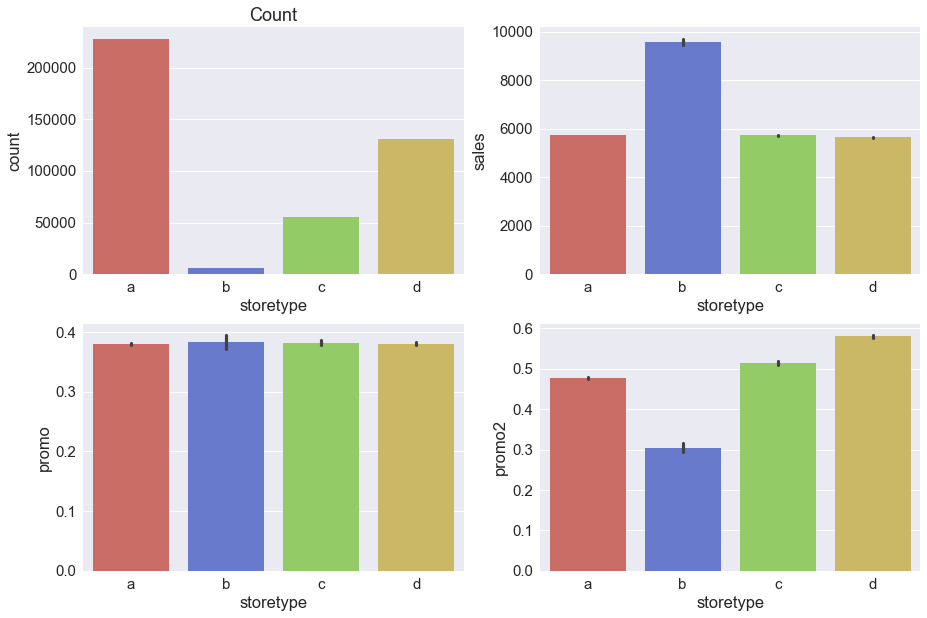

In [50]:
plt.figure(figsize=(15, 10))
plt.subplot(221)
plt.title('Count')
sns.countplot(x='storetype', data=sampled_df)
plt.subplot(222)
sns.barplot(x='storetype', y='sales', data=sampled_df)
plt.subplot(223)
sns.barplot(x='storetype', y='promo', data=sampled_df)
plt.subplot(224)
sns.barplot(x='storetype', y='promo2', data=sampled_df);

Based on those barcharts, we can make the following observations:
- Type 'b' stores are least common and have the least type 2 promotions, but makes significantely more sales (about 30%).
- The other types of stores ae about equals with regards to their sales generated.
- Type 1 promotions are equally common for all types of stores.

In [51]:
print_anova_results('storetype', 'sales')

                                ANOVA Results                            
Dep. Variable:                  sales   R-squared:                       0.015
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          5743.5484      1.792   3205.578      0.000    5740.037    5747.060
C(storetype)[T.b]  3802.7181     10.951    347.241      0.000    3781.254    3824.182
C(storetype)[T.c]   -26.1551      4.044     -6.468      0.000     -34.081     -18.230
C(storetype)[T.d]   -90.6784      2.968    -30.552      0.000     -96.496     -84.861


It is hard to say if there is a significant difference between different store types. While the average number of sales for type B is much higher than for the rest, the number of such stores is also relatively small, making them hardly repesentable for the whole dataset.

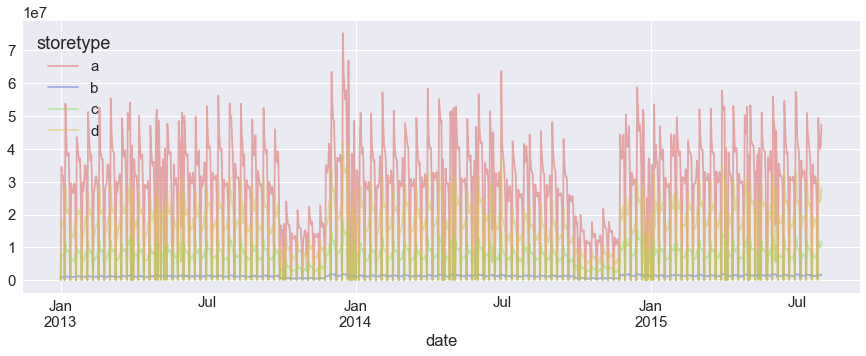

In [52]:
(train_df
 .groupby(['date', 'storetype'])['sales']
 .sum()
 .unstack()
 .plot(alpha=0.5, figsize=(15, 5)));

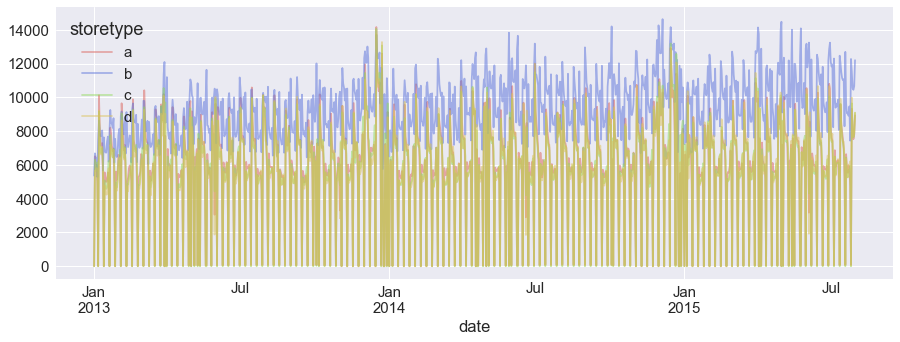

In [53]:
(train_df
 .groupby(['date', 'storetype'])['sales']
 .mean()
 .unstack()
 .plot(alpha=0.5, figsize=(15, 5)));

We see that the ratios of total sales by store do not change significantely over time.
The same is true for the average sales per day where type 'b' stores have constantely about a third more in sales while the other store types sell about the same, in accordance with our previous findings.

**Assortment** describes the decoration level of a store.

Three different types of assortments exist:
1. a = basic
2. b = extra
3. c = extended

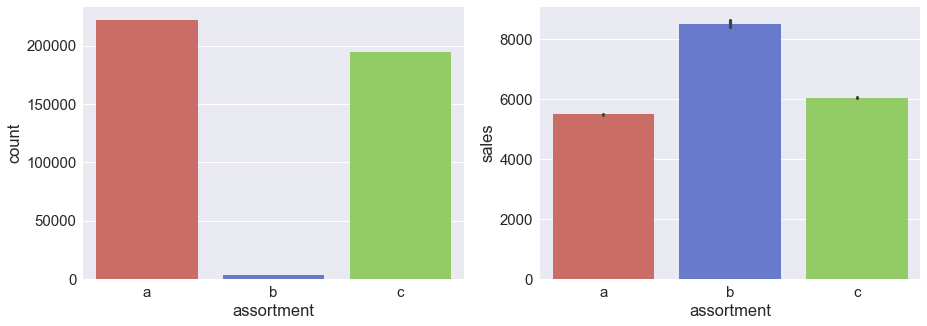

In [54]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
sns.countplot(x='assortment', data=sampled_df)
plt.subplot(122)
sns.barplot(x='assortment', y='sales', data=sampled_df);

While stores of assortment _b_ appear to make significantely more sales, they are very rare compared to the other types, makeing the different in sales subject to possible variability. Still, when considering types _a_ and _b_, there seems to be a trend of more sales for higher decoration levels.

In [55]:
print_anova_results('assortment', 'sales')

                                ANOVA Results                            
Dep. Variable:                  sales   R-squared:                       0.010
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           5477.9143      1.822   3005.979      0.000    5474.343    5481.486
C(assortment)[T.b]  3059.2154     14.617    209.293      0.000    3030.567    3087.864
C(assortment)[T.c]   570.2147      2.661    214.302      0.000     565.000     575.430


Even though ANOVA counts all differences as highly significant, we sould probaly still not overestimate their importance.

### Location

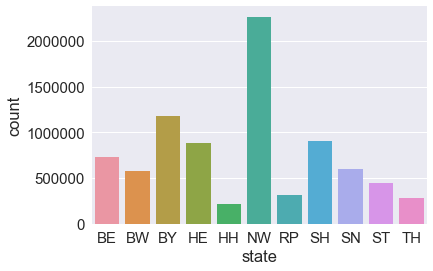

In [56]:
sns.countplot(train_df.state);

We notice that counts do not quite match up with the actual sizes of German states.
Also some states are missing.

In [57]:
print("States only in the train set: %s" % (set(train_df.state) - set(test_df.state)))
print("States only in the test set: %s" % (set(test_df.state) - set(train_df.state)))

States only in the train set: {'TH', 'ST', 'BE', 'SN'}
States only in the test set: set()


Interesting enough four states (all located in Eastern Germany) are only contained in the training set.
This gives rise to the suspicion that the test set is slightly biased towards Western Germany.
While new, previously unobserved states would cause some problems for later model training, the opposite is really much less of a problem.

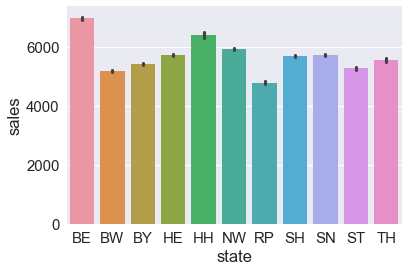

In [58]:
sns.barplot(x='state', y='sales', data=sampled_df);

When looking at the sales per state we observe that they do not relate to the size/population of their respective states.

### Competitors

NaN value fraction: 0.002662


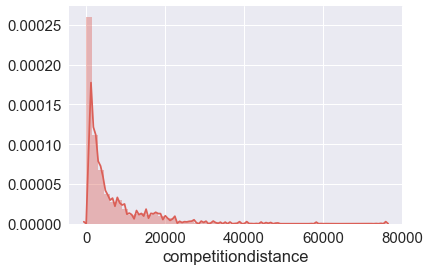

In [59]:
competitiondistance_len = len(train_df.competitiondistance)
competitiondistance_without_nan_len = len(train_df.competitiondistance.dropna())
print("NaN value fraction: %f"
      % (1 - competitiondistance_without_nan_len / competitiondistance_len))

sns.distplot(train_df.competitiondistance.dropna());

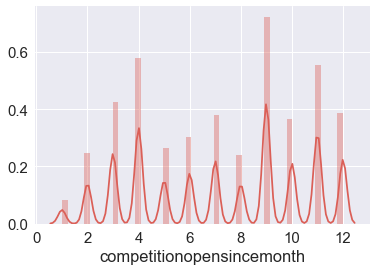

In [60]:
sns.distplot(train_df.competitionopensincemonth.dropna());

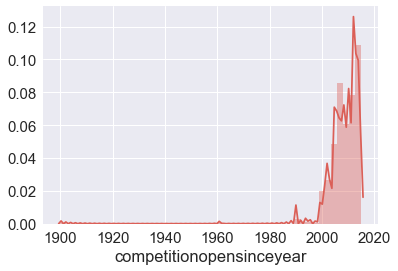

In [61]:
sns.distplot(train_df.competitionopensinceyear.dropna());

We see that the timely comptetition information is given in absolute dates.
Instead we should transform them in into the number of days (or months) passed since the competition has opened, which will be done in the _Feature Engineering_ section.

In [62]:
for df in df_list:
    df['competitiontenure'] = ((max(train_df.competitionopensinceyear)
                               - train_df.competitionopensinceyear) * 12)

### Weather

We are given the following weather phenomena:
- Temperature (in degrees Celcius)
- Dew Point
- Humidity
- Air pressure
- Visibility
- Wind speed and direction
- Cloudieness
- Events (special events like thunderstorms)

In [63]:
weather_columns = ['max_temperaturec', 'mean_temperaturec', 'min_temperaturec',
       'dew_pointc', 'meandew_pointc', 'min_dewpointc', 'max_humidity',
       'mean_humidity', 'min_humidity', 'max_sea_level_pressurehpa',
       'mean_sea_level_pressurehpa', 'min_sea_level_pressurehpa',
       'max_visibilitykm', 'mean_visibilitykm', 'min_visibilitykm',
       'max_wind_speedkm_h', 'mean_wind_speedkm_h', 'max_gust_speedkm_h',
       'precipitationmm', 'cloudcover', 'events', 'winddirdegrees']

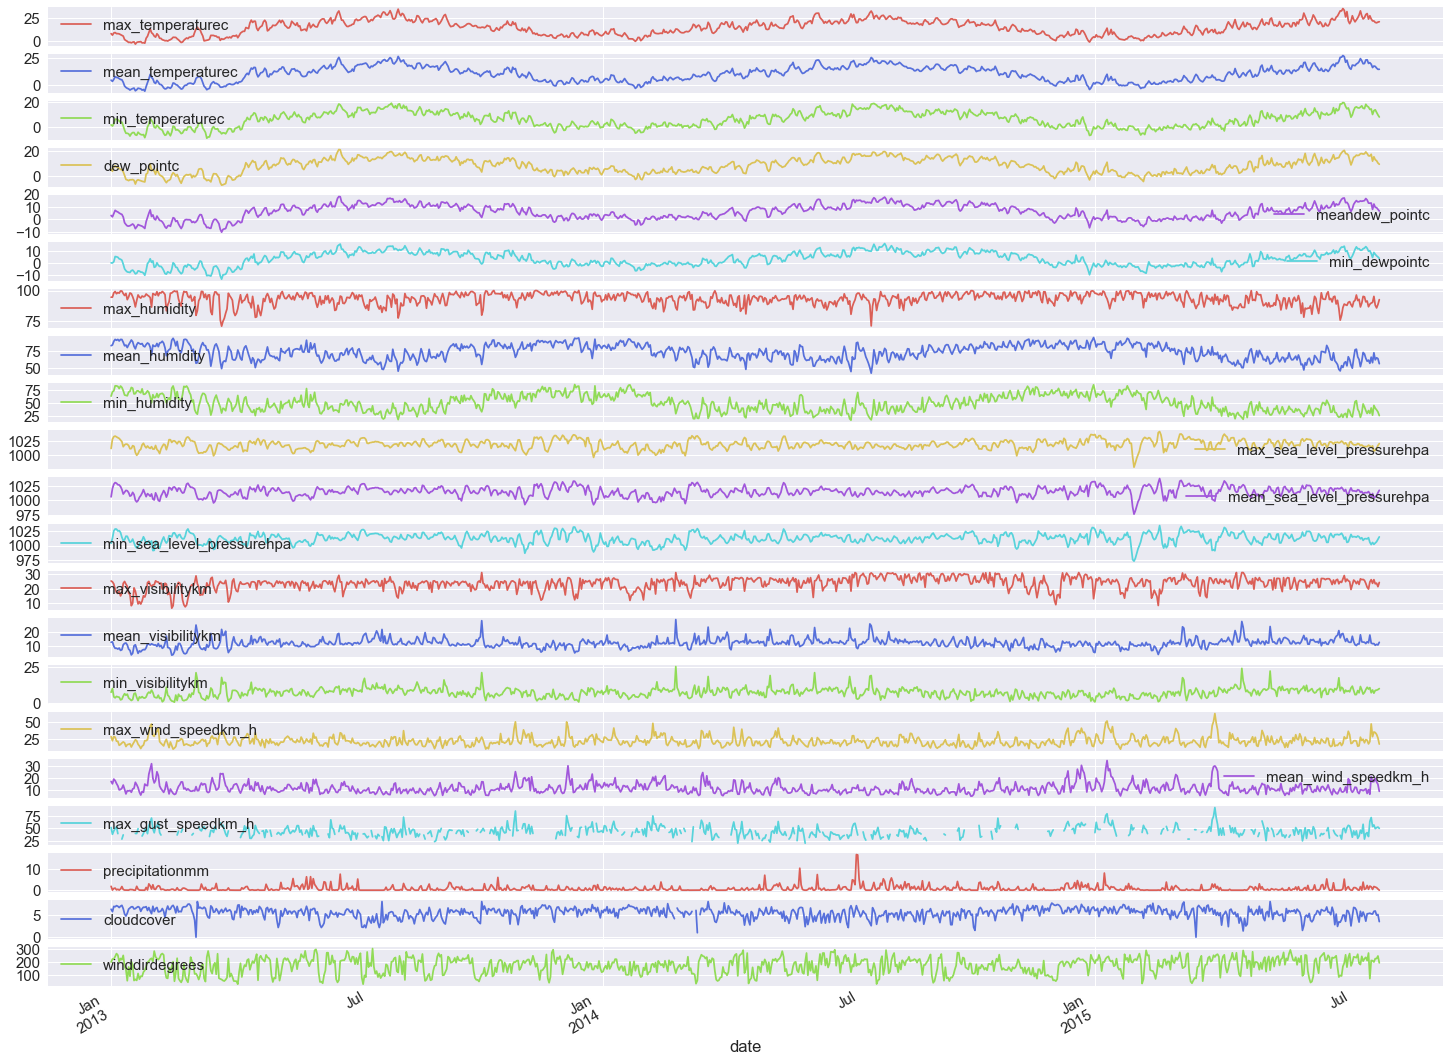

In [64]:
weather_history = (train_df.set_index(train_df.date)[weather_columns]
                   .resample('D').mean())
weather_history.plot(subplots=True, figsize=(25, 20))
del weather_history

While this is a lot to visually digest, we can quickly make some basic observations:
1. While for temperture and dew some (expected) yearly seasonality is observable, it is not for the other variables.
1. Most variables have strong variance that cannot be explained by seasonality (of course weather is somewhat random).
1. Many variables appear to be strongly correlated, both because some variables contain mean, minimum and maximum of the same underlying weather phenomenom.
1. More specifically, the max_gust_speedhm_h variable contains many NaN values. Also it seems to heavily correlate with the other wind speed observation because of which we should most likely disregard it for our later predictions.

In the following we will further explore our correlation presumtions.

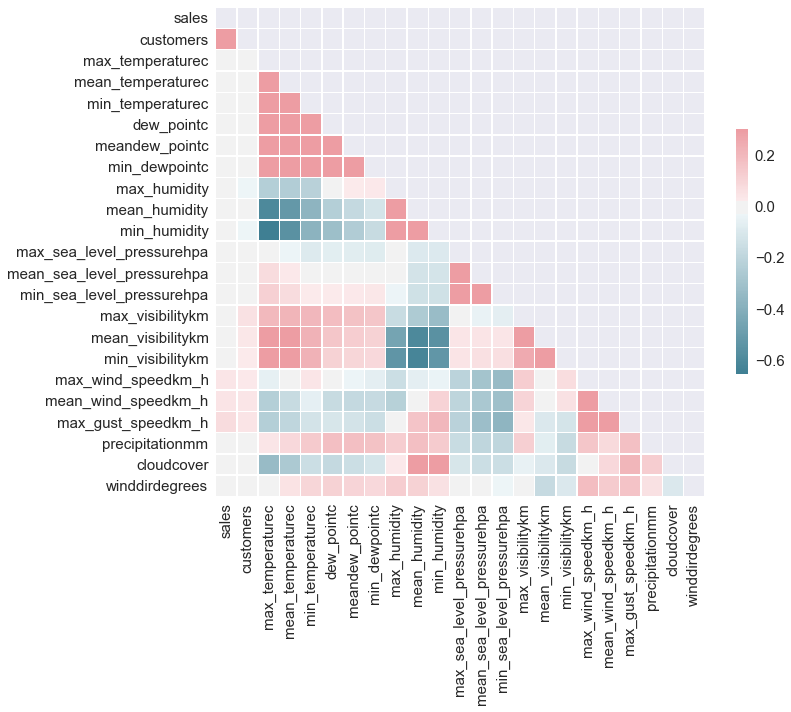

In [65]:
plot_correlation_matrix(train_df[['sales', 'customers'] + weather_columns])

While this shows some interesting correlations between different weather phenomena, they unfortunately related quite little to the sales number we are trying to predict in the first place.
The only stronger correlation to sales we can find is for wind speed, where a higher windspeed suposebly results in higher sales which is not quite intuitive.

On the other hand, we have to keep in mind that the used pearson correlation does not capture all types of corrlation, especially not non-linear correlations.
Yet, the Spearman's rank-order correlation shows similar results.

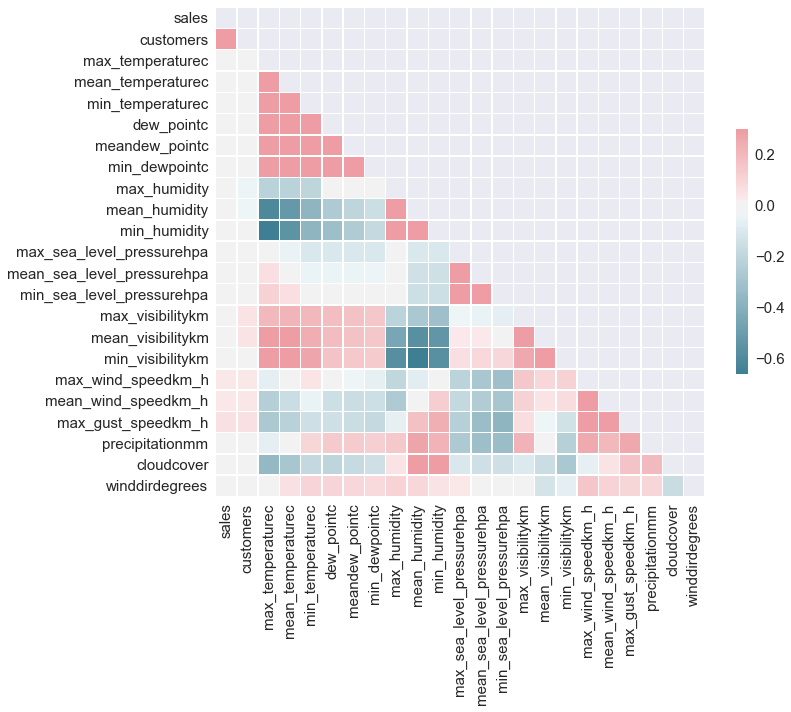

In [66]:
plot_correlation_matrix(train_df[['sales', 'customers'] + weather_columns], method='spearman')

### Google Trends

For each observation we have
1. The global Google trend for Germany
1. The local trend by the store's state

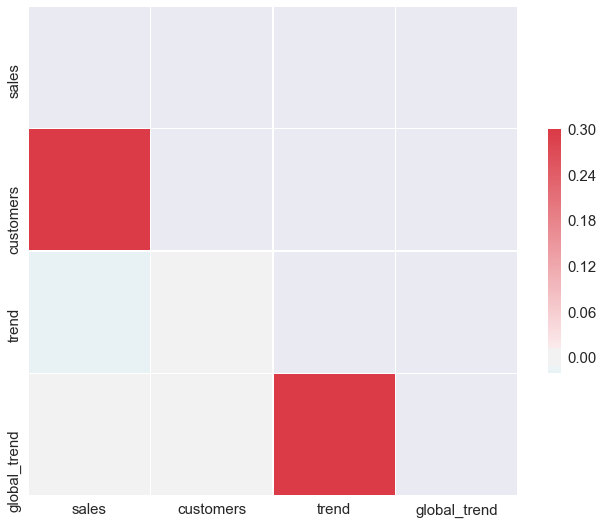

In [67]:
plot_correlation_matrix(train_df[['sales', 'customers', 'trend', 'global_trend']])

We see that the only two strong correlation are between customers/sales (as noticed ealier) and also the local and global trend do correlate which is not suprising.
Unfortunately, we cannot observe any correlation between Google trends and neither sales nor customer.

### Take aways

With _sales_ being our response variable, we found the following explanatory variables to be potentially good predictors for _sales_ (roughly ordered by descending relevance):
1. Open
1. Customers
1. Type 1 promo
1. Store type
1. State



## Feature Engineering

### Augmented Features

In [68]:
def fill_categorical_na(col_name, replacement_value):
    train_df[col_name] = train_df[col_name].astype('category')
    if replacement_value not in train_df[col_name].cat.categories:
        train_df[col_name] = train_df[col_name].cat.add_categories([replacement_value])
    train_df[col_name] = train_df[col_name].fillna(replacement_value)
    
    test_df[col_name] = test_df[col_name].astype('category')
    if replacement_value not in test_df[col_name].cat.categories:
        test_df[col_name] = test_df[col_name].cat.add_categories([replacement_value])
    test_df[col_name] = test_df[col_name].fillna(replacement_value)

In [69]:
def fill_numerical_na(col_name, replacement_value):
    train_df[col_name] = train_df[col_name].fillna(replacement_value)
    test_df[col_name] = test_df[col_name].fillna(replacement_value)

#### Promo

In [72]:
fill_categorical_na('promointerval', 'NONE')

Next we create a new column of how long the nearest competitor has been around.
The code for this looks slightly ugly because creating a date column from year and week is unfortunately not straightforward in Pandas.
Also, because we cannot retrieve the exact date from just year and week, we subtract 1 from the weak number to not end up with negative time deltas.
This means the resulting time delta will be off by something between 0 and 6 days.
Since this shift is applied to all dates, we assume that it will not significantly impact the accuracy of our later models.

In [73]:
train_df['promo2since'] = (train_df.date - pd.to_datetime(
    pd.concat([train_df['promo2sinceyear']
               .fillna(train_df.date.dt.year),
               train_df['promo2sinceweek']
               .fillna(train_df.date.dt.week)], axis=1)
    .apply(lambda x: '%d-%d-1' % (x[0], x[1]-1), axis=1), format='%Y-%W-%w')).dt.days
test_df['promo2since'] = (test_df.date - pd.to_datetime(
    pd.concat([test_df['promo2sinceyear']
               .fillna(test_df.date.dt.year),
               test_df['promo2sinceweek']
               .fillna(test_df.date.dt.week)], axis=1)
    .apply(lambda x: '%d-%d-1' % (x[0], x[1]-1), axis=1), format='%Y-%W-%w')).dt.days

In [74]:
# Sanity check that no negative time deltas exist.
min(train_df['promo2since'])
min(test_df['promo2since'])

0

#### Competition

Similarily to the promotions, we will fill non-existing values for the closest competitors distance with zeros and transform their open dates into he number of days passed since the have opened.

In [75]:
fill_numerical_na('competitiondistance', 0)

In [76]:
train_df['competitionsince'] = (train_df.date - pd.to_datetime(
    {'year': train_df.competitionopensinceyear,
     'month': train_df.competitionopensincemonth,
     'day': 1})).fillna(pd.Timedelta(0)).dt.days
test_df['competitionsince'] = (test_df.date - pd.to_datetime(
    {'year': test_df.competitionopensinceyear,
     'month': test_df.competitionopensincemonth,
     'day': 1})).fillna(pd.Timedelta(0)).dt.days

In [77]:
# Sanity check that no negative time deltas exist.
min(train_df['competitionsince'])
min(test_df['competitionsince'])

0

#### Weather

In our EDA we saw could not find a significant correlation between weather and sales.
Thus it would not make sense for half our our variables to be weather related.
Nevertheless, it might be smart to include a condense version of the weather activities in our predictive model.
To achieve this we will make use of dimensionality reduction, in order to condense all our weather variables into one single value per observation.

The only exception here are the _events_ and *max_gust_speedkm_h* variables.
_events_ is categorical and will thus be processed peperately with our other categorical variables.
*max_gust_speedkm_h* contains so many NA values that it is hard to make any sense of.

We thereby use PCA, instead of other popular methods likes t-SNE, mainly because of its simplicity and determinism.

First we have to remove NA values.

In [78]:
# Find out what weather columns contain NaNs.
train_df[weather_columns].isna().any()

max_temperaturec              False
mean_temperaturec             False
min_temperaturec              False
dew_pointc                    False
meandew_pointc                False
min_dewpointc                 False
max_humidity                  False
mean_humidity                 False
min_humidity                  False
max_sea_level_pressurehpa     False
mean_sea_level_pressurehpa    False
min_sea_level_pressurehpa     False
max_visibilitykm               True
mean_visibilitykm              True
min_visibilitykm               True
max_wind_speedkm_h            False
mean_wind_speedkm_h           False
max_gust_speedkm_h             True
precipitationmm               False
cloudcover                     True
events                         True
winddirdegrees                False
dtype: bool

In [79]:
for col_name in ['max_visibilitykm', 'mean_visibilitykm', 'min_visibilitykm', 'cloudcover']:
    train_df[col_name] = 0
    test_df[col_name] = 0

In [80]:
# Check that NAs have been removed.
train_df[weather_columns].isna().any()

max_temperaturec              False
mean_temperaturec             False
min_temperaturec              False
dew_pointc                    False
meandew_pointc                False
min_dewpointc                 False
max_humidity                  False
mean_humidity                 False
min_humidity                  False
max_sea_level_pressurehpa     False
mean_sea_level_pressurehpa    False
min_sea_level_pressurehpa     False
max_visibilitykm              False
mean_visibilitykm             False
min_visibilitykm              False
max_wind_speedkm_h            False
mean_wind_speedkm_h           False
max_gust_speedkm_h             True
precipitationmm               False
cloudcover                    False
events                         True
winddirdegrees                False
dtype: bool

In [81]:
from sklearn.decomposition import PCA

In [82]:
pca = PCA(n_components=1)
train_df['weather'] = (pca.fit_transform(train_df[weather_columns]
                                         .drop(['events', 'max_gust_speedkm_h'], axis=1)
                                         .values))
test_df['weather'] = (pca.transform(test_df[weather_columns]
                                    .drop(['events', 'max_gust_speedkm_h'], axis=1)
                                    .values))

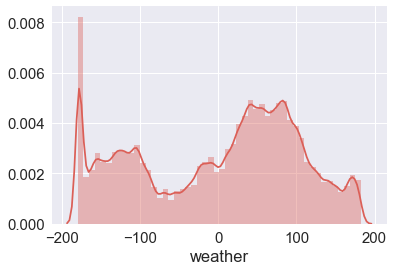

In [83]:
sns.distplot(train_df['weather']);

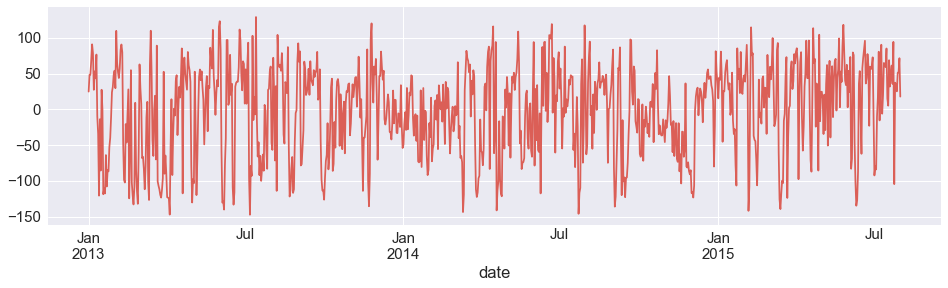

In [84]:
weather_pca_history = train_df.set_index(train_df.date).weather.resample('D').mean().plot(figsize=(16, 4));

While being quite noisey, we can observe a stronger variance during the middle of the year and a somewhat weaker variance during winter.

In [85]:
train_df[['weather', 'sales']].corr()

,weather,sales
weather,1.00000,0.00311
sales,0.00311,1.00000


Unfortunately, the correlation to the number of sales is really small.

### Clean up remaining NA values.

In [86]:
# First find all columns that contain NA values.
list(train_df.columns[train_df.isna().any()])

['competitionopensincemonth',
 'competitionopensinceyear',
 'promo2sinceweek',
 'promo2sinceyear',
 'max_gust_speedkm_h',
 'events',
 'competitiontenure']

Only variable left is _events_

In [87]:
fill_categorical_na('events', 'NONE')

### Build Datasets

In [88]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder

At this point, I decide to split the dataset into two types of data:
1. **Numerical data** with a clear ordinality like sales or customers (e.g. 100 sales are more than 10 sales)
1. **Categorical data** of which some is numerical but does not follow a clear ordinality (e.g. for months, May is not really more than January)

In the following, we define which columns we want to include under which category.
Columns not included can be regarded irrelevant as described in the EDA section.

In [90]:
categorical_columns = ['store',
                       'dayofweek',
                       'open',
                       'promo',
                       'stateholiday',
                       'schoolholiday',
                       'day',
                       'week',
                       'month',
                       'year',
                       'storetype',
                       'assortment',
#                        'competitionopensincemonth',
#                        'competitionopensinceyear',
                       'promo2',
#                        'promo2sinceweek',
#                        'promo2sinceyear',
                       'promointerval',
                       'state',
                       'events'
                      ]

numerical_columns = ['customers',
                     'competitiondistance',
                     'weather',
                     'competitionsince',
                     'promo2since'
                    ]

In [91]:
categorical_encoders = {}
# one_hot_encoders = {}

for category in categorical_columns:
    new_cat_encoder = LabelEncoder()
    encoded_vars = new_cat_encoder.fit_transform(train_df[category])
    
#     new_oh_encoder = OneHotEncoder(sparse=False)
#     new_oh_encoder.fit(encoded_vars.reshape(-1, 1))
    
    categorical_encoders[category] = new_cat_encoder
#     one_hot_encoders[category] = new_oh_encoder

In [92]:
def build_dataset(set_='train',
                  all_features=False,
                  validation_days=14,
                  one_hot_categories=False,
                  remove_zero_targets=False):
    if set_ in ['train', 'val']:
        max_date = max(train_df.date)
        pivot_date = max_date - pd.Timedelta(validation_days, unit='d')
        
        if set_ == 'train':
            data_df = train_df[train_df.date <= pivot_date]
        elif set_ == 'val':
            data_df = train_df[train_df.date > pivot_date]
    elif set_ == 'test':
        data_df = test_df
    else:
        raise ValueError("Only 'train', 'val', and 'test' are accepted"
                         + " as arguments")
        
    num_columns = numerical_columns if all_features else ['customers']
    num_values = data_df[num_columns].astype('float32').values

    # Scale numerical features.
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_values = [scaler.fit_transform(num_values)]
    
    encoded_values = []
    # Encode categorical features.
    cat_columns = categorical_columns if all_features else ['open', 'promo', 'storetype', 'state']
    for category in cat_columns:
        current_cat_values = data_df[category].values
        current_encoded_values = (categorical_encoders[category]
                                  .transform(current_cat_values)
                                  .reshape(-1, 1))
        if one_hot_categories:
            one_hot_values = (one_hot_encoders[category]
                              .transform(current_encoded_values))
            encoded_values.append(one_hot_values)
        else:
            encoded_values.append(current_encoded_values)
    
    feature_values = np.hstack(scaled_values + encoded_values)
    
    target_values = data_df[['sales']].values
    
    if remove_zero_targets:
        # This somewhat destroys the time series.
        # An alternative could be setting sales to 1 instead,
        # which should not make much of a difference.
        feature_values = feature_values[np.where(target_values > 0)[0]]
        target_values = target_values[np.where(target_values > 0)[0]].reshape((-1, ))
    
    return feature_values, target_values

Next, we build our preliminary datasets.

Even though our methods supports one-hot vectors, some experiments we have done showed inferior results on all used algorithms.
Therefore, we do not use one-hot vectors in the following.

In [93]:
train_data, train_target = build_dataset('train', remove_zero_targets=True)
print(train_data.shape)
val_data, val_target = build_dataset('val', remove_zero_targets=True)
print(val_data.shape)

(6857665, 5)
(118386, 5)


## Model Training and Evaluation

In [106]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import concatenate, Dense, Embedding, Input, Lambda, LSTM, Reshape
from keras.models import Model, Sequential
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb

In [95]:
import h5py
import pickle

Submissions are evaluated on the Root Mean Square Percentage Error (RMSPE). The RMSPE is calculated as
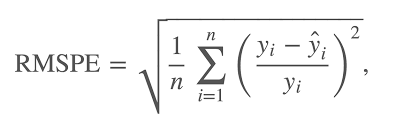
where y_i denotes the sales of a single store on a single day and yhat_i denotes the corresponding prediction. Any day and store with 0 sales is ignored in scoring.

In [96]:
def rmspe(prediction, target):
    if prediction.shape != target.shape:
        raise ValueError("Dimensions of prediction and target must match!"
                        + " 'prediction' is %s; 'target' is %s" % (prediction.shape, target.shape))
    return np.sqrt(np.sum(((target - prediction) / target)**2) / len(prediction))

# Test some some simple examples.
print(rmspe(np.array([1.0, 1.0]), np.array([1.0, 1.0])))
print(rmspe(np.array([1, 1]), np.array([2, 2])))

0.0
0.5


In [97]:
def plot_history(history):
    plt.plot(history['loss'], label='train')
    plt.plot(history['val_loss'], label='validation')
    plt.legend();

### Professional Baseline

The best entries in the Kaggle competition report an RMSPE of roughly 0.1.

### Median Baseline

As a simple baseline, we use the median of the sales in the training data for all predictions.

In [98]:
train_set_median = np.median(train_target)
non_zero_val_target = val_target[np.where(val_target > 0)[0]].reshape((-1, ))
baseline_prediction = np.ones(len(non_zero_val_target)) * train_set_median
print(rmspe(baseline_prediction, non_zero_val_target))

0.5231409006056749


### DecisionTreeRegressor

We start we as decision tree regressor.
This is one of the most simpel regression models (remember that we cannot use linear regression because its assumtions are not met).

Only based on customers:

In [99]:
# Train.
tree = DecisionTreeRegressor()
tree.fit(train_data[:, 1:2], train_target)

# Evaluate.
non_zero_val_data = val_data[np.nonzero(val_target)[0]]
non_zero_val_target = val_target[np.nonzero(val_target)[0]].reshape((-1, ))
tree_prediction = tree.predict(non_zero_val_data[:, 1:2])
print(rmspe(tree_prediction, non_zero_val_target))

0.5948576711435404


With a total of 5 variables:

In [100]:
# Train.
tree = DecisionTreeRegressor()
tree.fit(train_data, train_target)

# Evaluate.
non_zero_val_data = val_data[np.nonzero(val_target)[0]]
non_zero_val_target = val_target[np.nonzero(val_target)[0]].reshape((-1, ))
tree_prediction = tree.predict(non_zero_val_data)
print(rmspe(tree_prediction, non_zero_val_target))

0.5502106192375745


The results are of course underwhelming, considering it is about 20% worse than our median baseline.
One of the benefits of using decision trees is their easy interpretability.
Becaus of the bad results though, we will save our time and not visualize the trees but instead move on to some more sophisticated algorithms.

### XGBoost



Instead of trying to build one strong regressor like the decision tree, XGBoost creates many weak regressors and then tries to figure out which of those work best for different kinds of features.

In [101]:
#create a train and validation DMatrix objects.
xgtrain = xgb.DMatrix(train_data, label=train_target)
xgval = xgb.DMatrix(val_data, label=val_target)
xgtest = xgb.DMatrix(non_zero_val_data, label=val_target)

#train using early stopping and predict
watchlist = [(xgtrain, 'train'),(xgval, 'val')]

xgb_params = {'objective': 'reg:linear', 'eta': 0.1, 'min_child_weight': 6,
              'subsample': 0.87, 'colsample_bytree': 0.60,
              'scale_pos_weight': 1.0, 'silent': 1, 'max_depth': 7}

num_rounds = 50
xgb_model = xgb.train(xgb_params, xgtrain, num_rounds, watchlist, early_stopping_rounds=3)

[0]	train-rmse:6882.31	val-rmse:6533.61
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 3 rounds.
[1]	train-rmse:6225.25	val-rmse:5618.31
[2]	train-rmse:5712.03	val-rmse:5108.58
[3]	train-rmse:5174.88	val-rmse:4343.61
[4]	train-rmse:4755.74	val-rmse:3936.54
[5]	train-rmse:4322.23	val-rmse:3326.41
[6]	train-rmse:3988.53	val-rmse:3012.51
[7]	train-rmse:3642.76	val-rmse:2575.21
[8]	train-rmse:3384.43	val-rmse:2350.79
[9]	train-rmse:3159.73	val-rmse:2165.67
[10]	train-rmse:2896.25	val-rmse:1835.49
[11]	train-rmse:2725.67	val-rmse:1731.53
[12]	train-rmse:2518.04	val-rmse:1551.99
[13]	train-rmse:2393.59	val-rmse:1521.83
[14]	train-rmse:2287.88	val-rmse:1512.59
[15]	train-rmse:2135.57	val-rmse:1486.61
[16]	train-rmse:2002.72	val-rmse:1506.98
[17]	train-rmse:1936.25	val-rmse:1550.1
[18]	train-rmse:1875.33	val-rmse:1590.34
Stopping. Best iteration:
[15]	train-rmse:2135.57	val-rmse:1486.61



In [102]:
xgb_prediction = xgb_model.predict(xgtest)#.reshape(-1)
print(rmspe(xgb_prediction, non_zero_val_target))

0.2909769746310031


This is already a major improvement from our previous trees.

### Dense NN

To begin with, we create a simple shallow neural network:

In [108]:
num_features = train_data.shape[1]

dense_net = Sequential([
    Dense(10, input_shape=(num_features, ),
          kernel_initializer='normal',
          activation='relu'),
    Dense(1,
          kernel_initializer='normal')
])
dense_net.compile(loss='mse', optimizer='adam')

# Train NN.
history = dense_net.fit(train_data, train_target,
                        epochs=10, batch_size=200, shuffle=False,
                        validation_data=(val_data, val_target),
                        verbose=1)

Train on 6857665 samples, validate on 118386 samples
Epoch 1/10
6857665/6857665 [==============================] - 35s 5us/step - loss: 20460011.6171 - val_loss: 10392668.1048
Epoch 2/10
6857665/6857665 [==============================] - 35s 5us/step - loss: 9063822.3418 - val_loss: 6235378.1111
Epoch 3/10
6857665/6857665 [==============================] - 35s 5us/step - loss: 7004513.5999 - val_loss: 5324075.3069
Epoch 4/10
6857665/6857665 [==============================] - 35s 5us/step - loss: 6476135.7467 - val_loss: 4847904.8768
Epoch 5/10
6857665/6857665 [==============================] - 35s 5us/step - loss: 6012627.0348 - val_loss: 4400001.9733
Epoch 6/10
6857665/6857665 [==============================] - 36s 5us/step - loss: 5512325.5517 - val_loss: 3987577.5050
Epoch 7/10
6857665/6857665 [==============================] - 36s 5us/step - loss: 4961073.7067 - val_loss: 3656099.2623
Epoch 8/10
6857665/6857665 [==============================] - 36s 5us/step - loss: 4360895.6652 - 

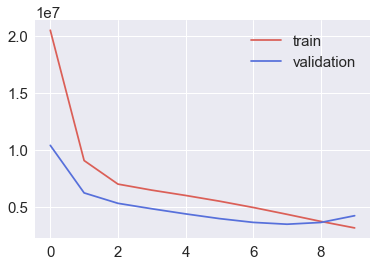

In [109]:
history_path = 'histories/shallow_densenet.pkl'
# with open(history_path, 'wb') as f:
#     pickle.dump(history.history, f, protocol=pickle.HIGHEST_PROTOCOL)

with open(history_path, 'rb') as f:
    history = pickle.load(f)
plot_history(history)

In [110]:
dense_prediction = dense_net.predict(non_zero_val_data).reshape(-1)
print(rmspe(dense_prediction, non_zero_val_target))

0.3949285111788048


We see that the networks starts overfitting after 7 epochs.
The resulting RMSPE is worse than XGBoost but still better than or median baseline.

Next, we try a wider and deeper NN:

In [111]:
num_features = train_data.shape[1]

dense_net = Sequential([
    Dense(50, input_shape=(num_features, ),
          kernel_initializer='normal',
          activation='relu'),
    Dense(10,
          kernel_initializer='normal',
          activation='relu'),
    Dense(1,
          kernel_initializer='normal')
])
dense_net.compile(loss='mse', optimizer='adam')

# Train NN.
history = dense_net.fit(train_data, train_target,
                        epochs=5, batch_size=200, shuffle=False,
                        validation_data=(val_data, val_target),
                        verbose=1)

Train on 6857665 samples, validate on 118386 samples
Epoch 1/5
6857665/6857665 [==============================] - 39s 6us/step - loss: 7694049.7110 - val_loss: 3306800.2938
Epoch 2/5
6857665/6857665 [==============================] - 39s 6us/step - loss: 2438583.3196 - val_loss: 5905389.4212
Epoch 3/5
6857665/6857665 [==============================] - 39s 6us/step - loss: 2362073.7433 - val_loss: 5911116.8341
Epoch 4/5
6857665/6857665 [==============================] - 39s 6us/step - loss: 2361821.6774 - val_loss: 5915727.9372
Epoch 5/5
6857665/6857665 [==============================] - 39s 6us/step - loss: 2361581.4247 - val_loss: 5920203.5845


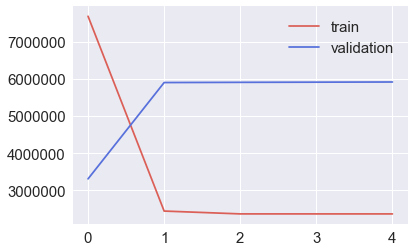

In [112]:
history_path = 'histories/bigger_densenet.pkl'
# with open(history_path, 'wb') as f:
#     pickle.dump(history.history, f, protocol=pickle.HIGHEST_PROTOCOL)

with open(history_path, 'rb') as f:
    history = pickle.load(f)
plot_history(history)

In [113]:
dense_prediction = dense_net.predict(non_zero_val_data).reshape(-1)
print(rmspe(dense_prediction, non_zero_val_target))

0.36212586712783884


As we see, the model overfits already after the first epoch and stagnates after the second one.
Nevertheless, the RMSPE is actually lower than for the shallow model.

### LSTM

Since we deal with time series which can be considered as sequential information, RNNs or more specifically LSTMs come into consideration.
One weird side note though is that instead from going from one date to the next one, the LSTM will stay at each date for the number of stores (we will try to fix that later).

In [116]:
num_features = train_data.shape[1]

# Define network architecture.
lstm_net = Sequential([
    LSTM(50, input_shape=(num_features, 1)),
    Dense(1)
])
lstm_net.compile(loss='mae', optimizer='adam')

# Train NN.
history = lstm_net.fit(train_data.reshape(-1, num_features, 1), train_target,
                       epochs=2, batch_size=72, shuffle=False,
                       validation_data=(val_data.reshape(-1, num_features, 1), val_target),
                       verbose=1)

Train on 6857665 samples, validate on 118386 samples
Epoch 1/2
6857665/6857665 [==============================] - 585s 85us/step - loss: 4627.7258 - val_loss: 2698.0345
Epoch 2/2
6857665/6857665 [==============================] - 590s 86us/step - loss: 2348.9551 - val_loss: 2197.4728


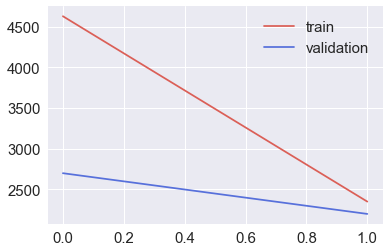

In [117]:
history_path = 'histories/lstm_history.pkl'
# with open(history_path, 'wb') as f:
#     pickle.dump(history.history, f, protocol=pickle.HIGHEST_PROTOCOL)

with open(history_path, 'rb') as f:
    history = pickle.load(f)
plot_history(history)

In [119]:
lstm_prediction = lstm_net.predict(non_zero_val_data.reshape(-1, num_features, 1)).reshape(-1)
print(rmspe(lstm_prediction, non_zero_val_target))

0.5013585790715696


While this is a very simple LSTM without advances tweaks like recurrent dropout, we results are not exactly overwhelming.
This might very well be due to the mentioned fact that the LSTM is not actually fed time series over which it could learn sequential patterns.

### With all features

In [120]:
# # Build full dataset.
# train_data, train_target = build_dataset('train',
#                                          all_features=True,
#                                          remove_zero_targets=True)
# print(train_data.shape)
# val_data, val_target = build_dataset('val',
#                                      all_features=True,
#                                      remove_zero_targets=True)
# print(val_data.shape)

At this point it might be smart to save the datset to disk in case our notebook needs to be restarted.

In [121]:
# data_to_save = [train_data, train_target, val_data, val_target]
# file_names = ['train_data_21', 'train_target', 'test_data_21', 'test_target']

# for data, fname in zip(data_to_save, file_names):
#     with open('data/' + fname + '.npy', 'wb') as f:
#         np.save(f, data)

In [137]:
!ls data/*.npy

data/test_data_21.npy  data/train_data_21.npy
data/test_target.npy   data/train_target.npy


In [138]:
def load_dataset(fname):
    with open(fname, 'rb') as f:
        data = np.load(fname)
    return data

In [139]:
train_data = load_dataset('data/train_data_21.npy')
train_target = load_dataset('data/train_target.npy')
val_data = load_dataset('data/test_data_21.npy')
val_target = load_dataset('data/test_target.npy')

#### XGBoost

In [140]:
xgtrain = xgb.DMatrix(train_data, label=train_target)
xgval = xgb.DMatrix(val_data, label=val_target)
xgtest = xgb.DMatrix(val_data, label=val_target)

#train using early stopping and predict
watchlist = [(xgtrain, 'train'),(xgval, 'val')]

xgb_params = {'objective': 'reg:linear', 'eta': 0.1, 'min_child_weight': 6,
              'subsample': 0.87, 'colsample_bytree': 0.60,
              'scale_pos_weight': 1.0, 'silent': 1, 'max_depth': 7}

num_rounds = 50
xgb_model = xgb.train(xgb_params, xgtrain, num_rounds, watchlist, early_stopping_rounds=3)

[0]	train-rmse:6880.18	val-rmse:6541.96
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 3 rounds.
[1]	train-rmse:6295.11	val-rmse:5945.36
[2]	train-rmse:5773.82	val-rmse:5408.05
[3]	train-rmse:5227.25	val-rmse:4622.75
[4]	train-rmse:4809.93	val-rmse:4224.71
[5]	train-rmse:4427.58	val-rmse:3864.42
[6]	train-rmse:4094.14	val-rmse:3537.78
[7]	train-rmse:3806.16	val-rmse:3256.56
[8]	train-rmse:3466.13	val-rmse:2754.24
[9]	train-rmse:3241.75	val-rmse:2565.46
[10]	train-rmse:3033.61	val-rmse:2384.55
[11]	train-rmse:2853.58	val-rmse:2234.52
[12]	train-rmse:2626.93	val-rmse:1955.24
[13]	train-rmse:2413.77	val-rmse:1704.44
[14]	train-rmse:2231.59	val-rmse:1547.2
[15]	train-rmse:2060.08	val-rmse:1431.23
[16]	train-rmse:1966.14	val-rmse:1428.75
[17]	train-rmse:1886.75	val-rmse:1436.52
[18]	train-rmse:1761.87	val-rmse:1445.89
[19]	train-rmse:1650.54	val-rmse:1499.86
Stopping. Best iteration:
[16]	train-rmse:1966.14	v

In [141]:
xgb_prediction = xgb_model.predict(xgtest)
print(rmspe(xgb_prediction, val_target))

0.2752612133768669


To our surprise, even when given all the data, XGBoost performs only slightly better than with only five features.
This could either be because of a bad choice of hyperparameters or the fact that the alogrithm cannot pick up much information from the additional features.

### Dense NN

In [142]:
num_features = train_data.shape[1]

dense_net = Sequential([
    Dense(50, input_shape=(num_features, ),
          kernel_initializer='normal',
          activation='relu'),
    Dense(10,
          kernel_initializer='normal',
          activation='relu'),
    Dense(1,
          kernel_initializer='normal')
])
dense_net.compile(loss='mse', optimizer='adam')

es_callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, mode='auto')
mc_callback = ModelCheckpoint('/tmp/densenet_weights.h5', monitor='val_loss',
                               save_best_only=True, save_weights_only=True)

# Train NN.
history = dense_net.fit(train_data, train_target,
                        epochs=50, batch_size=200, shuffle=False,
                        validation_data=(val_data, val_target),
                        callbacks=[es_callback, mc_callback],
                        verbose=1)

Train on 6857665 samples, validate on 118386 samples
Epoch 1/50
6857665/6857665 [==============================] - 42s 6us/step - loss: 9590117.2152 - val_loss: 9871314.7728
Epoch 2/50
6857665/6857665 [==============================] - 40s 6us/step - loss: 7591643.6347 - val_loss: 9362439.6737
Epoch 3/50
6857665/6857665 [==============================] - 37s 5us/step - loss: 6536155.1964 - val_loss: 6819098.3139
Epoch 4/50
6857665/6857665 [==============================] - 38s 6us/step - loss: 4464603.5769 - val_loss: 2636910.7908
Epoch 5/50
6857665/6857665 [==============================] - 42s 6us/step - loss: 2557778.4602 - val_loss: 3628888.2251
Epoch 6/50
6857665/6857665 [==============================] - 42s 6us/step - loss: 2231010.9172 - val_loss: 4016922.8344
Epoch 7/50
6857665/6857665 [==============================] - 43s 6us/step - loss: 2179603.4341 - val_loss: 3768090.7232


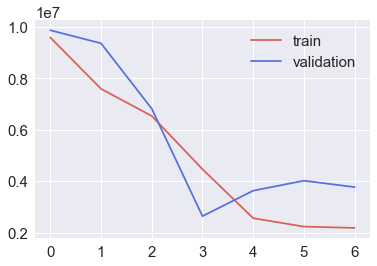

In [143]:
history_path = 'histories/all_features_densenet.pkl'
# with open(history_path, 'wb') as f:
#     pickle.dump(history.history, f, protocol=pickle.HIGHEST_PROTOCOL)

with open(history_path, 'rb') as f:
    history = pickle.load(f)
plot_history(history)

In [144]:
dense_net.load_weights('/tmp/densenet_weights.h5')
dense_prediction = dense_net.predict(val_data).reshape(-1)
print(rmspe(dense_prediction, val_target))

0.21137458253522576


The results from our NN on the other hand are more satisfying as it basically halfs the error compared to before.

### Categorical Embeddings

One last approach we will try is using embeddings for our categorical features:
The motivation behind this is that most algorithms are better at drawing boundaries in continuous numerical spaces than in discrete categorical ones.
Yet, only 5 of our features are numerical while the strong majority is categorical.
Do deal with this issue we will transform each category into a higher dimensional vector space, similar to word or document embeddings widely used in NLP these days.

In [145]:
num_numerical_features = len(numerical_columns)
print("%d numerical features" % num_numerical_features)
num_categorical_features = len(categorical_columns)
print("%d categorical features" % num_categorical_features)

5 numerical features
16 categorical features


In [150]:
embedding_size = 20

inputs = Input(shape=(num_features, ))
embedding_layers = []
for i in range(num_categorical_features):
    # The position of the feature in the dataset.
    cat_pos = num_numerical_features + i
    # The number of values the feature can take.
    num_cat_values = int(max(train_data[:, cat_pos]) + 1)
    split_layer = Lambda(lambda x: x[:, cat_pos], output_shape=(1, ))(inputs)
    emb_layer = Embedding(num_cat_values, embedding_size)(split_layer)
    embedding_layers.append(emb_layer)
    
merge_layer = concatenate(embedding_layers)
reshape_layer = Reshape((num_categorical_features * embedding_size, ))(merge_layer)

fc = Dense(50, activation='relu')(reshape_layer)
outputs = Dense(1)(fc)
embeddings_net = Model(inputs=inputs, outputs=outputs)
embeddings_net.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 21)           0                                            
__________________________________________________________________________________________________
lambda_17 (Lambda)              (None, 1)            0           input_3[0][0]                    
__________________________________________________________________________________________________
lambda_18 (Lambda)              (None, 1)            0           input_3[0][0]                    
__________________________________________________________________________________________________
lambda_19 (Lambda)              (None, 1)            0           input_3[0][0]                    
__________________________________________________________________________________________________
lambda_20 

In [147]:
# embeddings_net.compile(loss='mse', optimizer='adam')

# es_callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, mode='auto')
# mc_callback = ModelCheckpoint('models/embedding_weights.h5', monitor='val_loss',
#                                save_best_only=True, save_weights_only=True)

# history = embeddings_net.fit(train_data, train_target,
#                         epochs=50, batch_size=200, shuffle=False,
#                         validation_data=(val_data, val_target),
#                         callbacks=[es_callback, mc_callback],
#                         verbose=1)

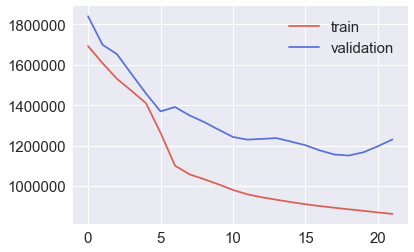

In [148]:
history_path = 'histories/embeddings_history.pkl'
# with open(history_path, 'wb') as f:
#     pickle.dump(history.history, f, protocol=pickle.HIGHEST_PROTOCOL)

with open(history_path, 'rb') as f:
    history = pickle.load(f)
plot_history(history)

In [151]:
embeddings_net.load_weights('models/embedding_weights.h5')
embeddings_prediction = embeddings_net.predict(val_data).reshape(-1)
print(rmspe(embeddings_prediction, val_target))

0.1662160318221924


We see that our networks starts to overfit after 17 epochs, leaving us with an RMSPE of roughly 0.17.
This already comes quite close to our "professional baseline".

## Future Work

While our last model already achieved quite good results, there are still many options left to explore, some of which will surely improve our results even further.

#### Actual Time Series
One caveat of all the model we built is that they do not correctly take time series into account.
Rather than trying to predict the sales from the features for a particular store on that day, we should also include a number of days from the past into our prediction.
This comes with some challenges though:
First of all, it would in the worst case square the size of our data and therefore also the training times of our models.
Also, since we removed some observation with zero sales, this would falsify our results unless we find a good solution for this issue.
Nevertheless, with more time at hand, this seems like the most promising direction to further investigate.

#### Combine Models
We saw that our LSTM performed somewhat better than our fully connected NN.
Considering that the categorical embeddings significantly improved the fully connected NN, we can assume that they will also improve the LSTM.

#### Ensembles
Joining various models together as an ensemble is usually what win data science/machine learning competitions.
We could train some more "weaker" regressors and hope that the ensemble picks up the individual regressors strengths, combining them into a more error-prone ensemble of models.

#### Hyperparameter Optimization
Maybe the biggest potential left with our models is the challenge of finding an optimal set of hyperparameters.
Since our choices of hyperparameters are based on a mixture of guessing and intuition, they have most likely still a lot of room for improvement.
However, even methods like Particle Swarm Optimization or Bayesian Optimization, which are much more efficient than naive grid search, would require way too much time with the resources at hand (a common notebook).



## Conclusion

In this notebook we approached the Rossmann Sales Prediction challenge by using a number of anaytical and statistical methods.

Rather than just focusing on getting good results quickly (which could be easily achieved using tools like [AutoML](http://www.ml4aad.org/automl/)), we focused on getting a better understanding of the business domain as well as the data and how different variables relate to each other.
We then picked a number of appropriate 
I believe that this approach requires more understanding of the problem/data and also better show my qualification as a data scientist/machine learning engineer.

After all, we have achieved a score which comes quite close to the leaders in the competition.
While we are still worse by a significant margin, we have to keep in mind that we have used neither hyperparameter tuning nor ensemble models, both which would have further boosted our score.